In [1]:
# 1. Instalación de dependencias
%pip install tensorflow fiftyone

  Using cached tabulate-0.9.0-py3-none-any.whl.metadata (34 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached dnspython-2.7.0-py3-none-any.whl.metadata (5.8 kB)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 12.1 MB/s  0:00:00m0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 4.5 MB/s  0:00:00m eta 0:00:01
Using cached dnspython-2.7.0-py3-none-any.whl (313 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.3/943.3 kB 3.0 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 17.4 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 2.6 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 20.2 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 8.5 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import fiftyone.zoo as foz

# Descargamos subconjunto pequeño de Open Images
dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="validation",
    label_types=["detections"],
    classes=["Person", "Chair", "Cup", "Book", "Car", "Cat"],
    max_samples=200
)
print("Samples:", len(dataset))


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/open-images-v6/validation' if necessary


Ignoring invalid classes ['Cup']
You can view the available classes via `fiftyone.utils.openimages.get_classes()`


You can view the available classes via `fiftyone.utils.openimages.get_classes()`


Necessary images already downloaded


INFO:fiftyone.utils.openimages:Necessary images already downloaded


Existing download of split 'validation' is sufficient


INFO:fiftyone.zoo.datasets:Existing download of split 'validation' is sufficient


Loading existing dataset 'open-images-v6-validation-200'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


INFO:fiftyone.zoo.datasets:Loading existing dataset 'open-images-v6-validation-200'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use


Samples: 200


In [ ]:
import numpy as np
import tensorflow as tf
import cv2

IMG_SIZE = 128  # reducimos tamaño por simplicidad
CLASSES = ["Person", "Chair", "Cup", "Book", "Car", "Cat"]
class_to_idx = {c: i for i, c in enumerate(CLASSES)}

images, labels, bboxes = [], [], []

for sample in dataset:
    img = cv2.imread(sample.filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0

    for det in sample.ground_truth.detections:
      if det.label in class_to_idx:
        ymin, xmin, ymax, xmax = det.bounding_box
        labels.append(class_to_idx[det.label])
        bboxes.append([ymin, xmin, ymax, xmax])
        images.append(img)

images = np.array(images)
labels = np.array(labels)
bboxes = np.array(bboxes)

print("Dataset shape:", images.shape, labels.shape, bboxes.shape)

Dataset shape: (507, 128, 128, 3) (507,) (507, 4)


In [ ]:
from tensorflow.keras import layers, models, Input

def build_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=len(CLASSES)):
    inputs = Input(shape=input_shape)

    # Backbone CNN
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu")(x)

    # Cabeza de clasificación
    class_out = layers.Dense(num_classes, activation="softmax", name="class_output")(x)

    # Cabeza de regresión (bounding boxes)
    bbox_out = layers.Dense(4, activation="sigmoid", name="bbox_output")(x)

    model = models.Model(inputs, [class_out, bbox_out])
    return model

model = build_cnn()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32768)     │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  8,388,864 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 6)         │      1,542 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │      1,028 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,484,682 (32.37 MB)

 Trainable params: 8,484,682 (32.37 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer="adam",
    loss={
        "class_output": "sparse_categorical_crossentropy",
        "bbox_output": "mse"
    },
    loss_weights={
        "class_output": 1.0,
        "bbox_output": 2.0  # damos más importancia a precisión de boxes
    },
    metrics={"class_output": "accuracy"}
)

history = model.fit(
    images, {"class_output": labels, "bbox_output": bboxes},
    epochs=10,
    batch_size=16,
    validation_split=0.2
)

Epoch 1/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 19s 642ms/step - bbox_output_loss: 0.0926 - class_output_accuracy: 0.4943 - class_output_loss: 1.0756 - loss: 1.2619 - val_bbox_output_loss: 0.0929 - val_class_output_accuracy: 0.6275 - val_class_output_loss: 1.2451 - val_loss: 1.4587
Epoch 2/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 644ms/step - bbox_output_loss: 0.0917 - class_output_accuracy: 0.7227 - class_output_loss: 0.6113 - loss: 0.7955 - val_bbox_output_loss: 0.0900 - val_class_output_accuracy: 0.4804 - val_class_output_loss: 1.2111 - val_loss: 1.3945
Epoch 3/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 645ms/step - bbox_output_loss: 0.0659 - class_output_accuracy: 0.8294 - class_output_loss: 0.3995 - loss: 0.5321 - val_bbox_output_loss: 0.0892 - val_class_output_accuracy: 0.5588 - val_class_output_loss: 1.3557 - val_loss: 1.5517
Epoch 4/10
26/26 ━━━━━━━━━━━━━━━━━━━━ 22s 694ms/step - bbox_output_loss: 0.0586 - class_output_accuracy: 0.8959 - class_output_loss: 0.2662 - loss: 0.3833 - val_bbox_output_loss: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


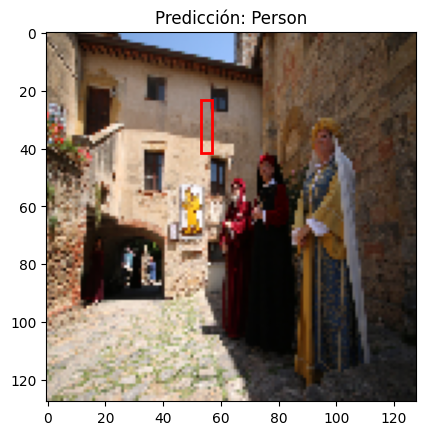

In [ ]:
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(images))
img = np.expand_dims(images[idx], axis=0)

pred_class, pred_bbox = model.predict(img)
pred_class = np.argmax(pred_class[0])
pred_bbox = pred_bbox[0]

plt.imshow(images[idx])
plt.title(f"Predicción: {CLASSES[pred_class]}")
h, w, _ = images[idx].shape
ymin, xmin, ymax, xmax = pred_bbox
plt.gca().add_patch(plt.Rectangle(
    (xmin*w, ymin*h), (xmax-xmin)*w, (ymax-ymin)*h,
    fill=False, color="red", linewidth=2
))
plt.show()